In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#####################################################
from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_TRATADOS
from src.config import DADOS_CATEGORIZADOS
from src.graficos import (
    plot_coeficientes,
    plot_residuos
)
#####################################################
from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor
)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score
)
from sklearn.model_selection import (
    cross_validate,
    KFold
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    QuantileTransformer,
    StandardScaler
)
#####################################################
sns.set_theme(palette='bright')
#####################################################
RANDOM_STATE = 42

In [2]:
df = pd.read_parquet(DADOS_CATEGORIZADOS)

df.head()

,idade,sexo,imc,pressao_media,colesterol_total,ldl,hdl,triglicerides,glicose,target,colesterol_hdl_cat
0,59,2,32.099998,101.0,157,93.199997,38.0,4.8598,87,151,4-5
1,48,1,21.600000,87.0,183,103.199997,70.0,3.8918,69,75,2-3
2,72,2,30.500000,93.0,156,93.599998,41.0,4.6728,85,141,4-5
3,24,1,25.299999,84.0,198,131.399994,40.0,4.8903,89,206,4-5
4,50,1,23.000000,101.0,192,125.400002,52.0,4.2905,80,135,4-5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   idade               442 non-null    int8    
 1   sexo                442 non-null    int8    
 2   imc                 442 non-null    float32 
 3   pressao_media       442 non-null    float32 
 4   colesterol_total    442 non-null    int16   
 5   ldl                 442 non-null    float32 
 6   hdl                 442 non-null    float32 
 7   triglicerides       442 non-null    float32 
 8   glicose             442 non-null    int8    
 9   target              442 non-null    int16   
 10  colesterol_hdl_cat  442 non-null    category
dtypes: category(1), float32(5), int16(2), int8(3)
memory usage: 12.3 KB


In [4]:
colunas_power_transform = ['imc', 'ldl', 'hdl', 'colesterol_total']

coluna_target = ['target']

coluna_ordinal_encoder = ['colesterol_hdl_cat']

coluna_one_hot_encoder = ['sexo']

colunas_standard_scaler = [
    coluna for coluna in df.columns
        if coluna not in colunas_power_transform + coluna_target + coluna_ordinal_encoder + coluna_one_hot_encoder
]

colunas_standard_scaler

['idade', 'pressao_media', 'triglicerides', 'glicose']

In [5]:
categorias_ordinal_encoder = [['2-3', '4-5', '6+']]

In [6]:
X = df.drop(columns='target')
y = df['target']

In [7]:
preprocessamento = ColumnTransformer(
    [
        ('power_transform', PowerTransformer(method='box-cox'), colunas_power_transform),
        ('standard_scaler', StandardScaler(), colunas_standard_scaler),
        ('ordinal_encoder', OrdinalEncoder(categories=categorias_ordinal_encoder), coluna_ordinal_encoder),
        ('one_hot_encoder', OneHotEncoder(drop='if_binary'), coluna_one_hot_encoder)
    ]
)

In [8]:
pipeline = Pipeline([
    ('preprocessor', preprocessamento),
    ('reg', LinearRegression())
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('power_transform',
                                                  PowerTransformer(method='box-cox'),
                                                  ['imc', 'ldl', 'hdl',
                                                   'colesterol_total']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['idade', 'pressao_media',
                                                   'triglicerides',
                                                   'glicose']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['2-3',
                                                                              '4-5',
                                                                              '6+']]),
                                                  ['colesterol_hdl_cat']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['sexo'])])),
                ('reg', LinearRegression())])

In [9]:
regressor = TransformedTargetRegressor(
    regressor=pipeline,
    transformer=QuantileTransformer(n_quantiles=20, output_distribution='normal')
)

regressor

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('power_transform',
                                                                                       PowerTransformer(method='box-cox'),
                                                                                       ['imc',
                                                                                        'ldl',
                                                                                        'hdl',
                                                                                        'colesterol_total']),
                                                                                      ('standard_scaler',
                                                                                       StandardScaler(),
                                                                                       ['idade',
                                                                                        'pressao_media',
                                                                                        'triglicerides',
                                                                                        'glicose']),
                                                                                      ('ordinal_encoder',
                                                                                       OrdinalEncoder(categories=[['2-3',
                                                                                                                   '4-5',
                                                                                                                   '6+']]),
                                                                                       ['colesterol_hdl_cat']),
                                                                                      ('one_hot_encoder',
                                                                                       OneHotEncoder(drop='if_binary'),
                                                                                       ['sexo'])])),
                                                     ('reg',
                                                      LinearRegression())]),
                           transformer=QuantileTransformer(n_quantiles=20,
                                                           output_distribution='normal'))

In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scores = cross_validate(
    regressor,
    X,
    y,
    cv=kf,
    scoring=[
        'r2',
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_root_mean_squared_error'
    ]
)

scores

{'fit_time': array([0.10757971, 0.05125427, 0.04384351, 0.03599644, 0.06396294]),
 'score_time': array([0.01184201, 0.01073241, 0.00703144, 0.01072001, 0.01925421]),
 'test_r2': array([0.45111029, 0.57091426, 0.38387446, 0.57951992, 0.39804147]),
 'test_neg_mean_absolute_error': array([-42.03727017, -40.89694788, -47.25777034, -42.49541026,
        -46.10165325]),
 'test_neg_mean_squared_error': array([-2908.10095648, -2676.89836286, -3353.52732788, -2829.98035923,
        -3363.49179362]),
 'test_neg_root_mean_squared_error': array([-53.92681111, -51.73875108, -57.90964797, -53.19755971,
        -57.99561875])}

In [11]:
scores_df = pd.DataFrame(scores)

scores_df

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.107580,0.011842,0.451110,-42.037270,-2908.100956,-53.926811
1,0.051254,0.010732,0.570914,-40.896948,-2676.898363,-51.738751
2,0.043844,0.007031,0.383874,-47.257770,-3353.527328,-57.909648
3,0.035996,0.010720,0.579520,-42.495410,-2829.980359,-53.197560
4,0.063963,0.019254,0.398041,-46.101653,-3363.491794,-57.995619


In [12]:
scores_df.describe()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.060527,0.011916,0.476692,-43.757810,-3026.399760,-54.953678
std,0.028248,0.004487,0.093417,2.760515,314.392231,2.848918
min,0.035996,0.007031,0.383874,-47.257770,-3363.491794,-57.995619
25%,0.043844,0.010720,0.398041,-46.101653,-3353.527328,-57.909648
50%,0.051254,0.010732,0.451110,-42.495410,-2908.100956,-53.926811
75%,0.063963,0.011842,0.570914,-42.037270,-2829.980359,-53.197560
max,0.107580,0.019254,0.579520,-40.896948,-2676.898363,-51.738751


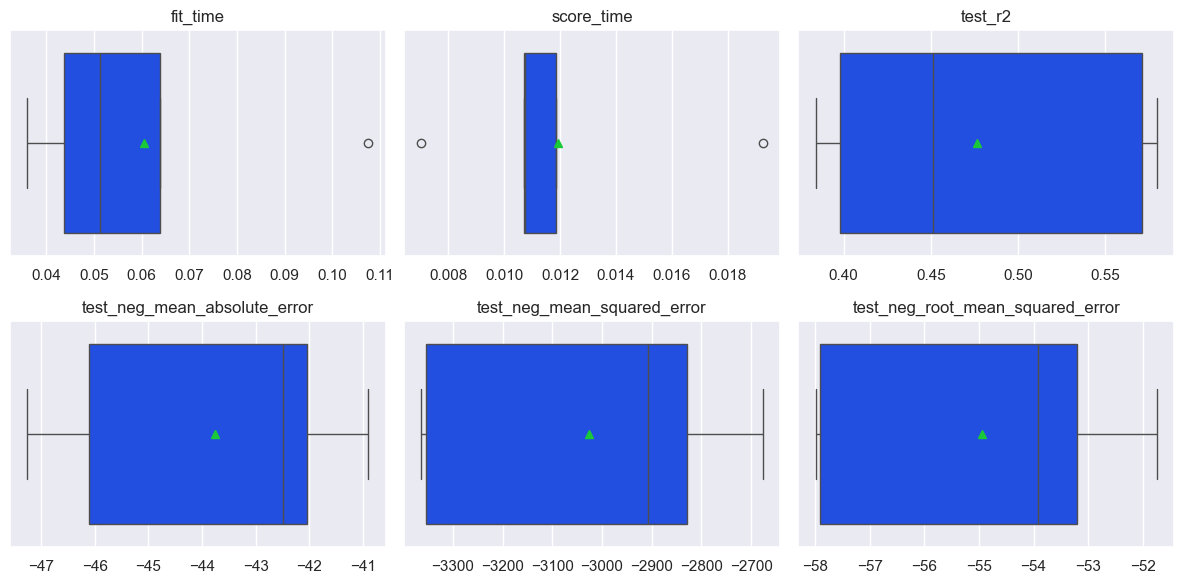

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for ax, score in zip(axs.flatten(), scores.keys()):
    sns.boxplot(
        x=scores[score],
        ax=ax,
        showmeans=True
    )
    ax.set_title(score)

plt.tight_layout()
plt.show()